ToDo:
* Try other cost functions 

In [1]:
clear

In [2]:
import pickle
import tensorflow as tf
import numpy as np
import tf_util
import gym
import load_policy
import matplotlib.pyplot as plt

tf Graph Input

In [3]:
def nn(input):

    with tf.name_scope('layer1'):
        W0 = tf.Variable(tf.truncated_normal([11, 30], stddev=0.1))
        b0 = tf.Variable(tf.constant(value=0.1, shape=[30]))
        h0 = tf.matmul(input, W0) + b0

    with tf.name_scope('layer2'):
        W1 = tf.Variable(tf.truncated_normal([30, 30], stddev=0.1))
        b1 = tf.Variable(tf.constant(value=0.1, shape=[30]))
        h1 = tf.matmul(h0, W1) + b1

    with tf.name_scope('layer3'):
        W2 = tf.Variable(tf.truncated_normal([30, 3], stddev=0.1))
        b2 = tf.Variable(tf.constant(value=0.1, shape=[3]))
        h2 = tf.matmul(h1, W2) + b2

    return h2

In [4]:
expert_policy_file = "experts/Hopper-v1.pkl"
envname = "Hopper-v1"
render = False
num_rollouts = 5

In [5]:
policy_fn = load_policy.load_policy(expert_policy_file)

('obs', (1, 11), (1, 11))


SET UP tensorflow    

In [6]:
input = tf.placeholder(tf.float32, shape=(1,11))
label = tf.placeholder(tf.float32, shape=(1,3))
pred = nn(input)

cost = tf.losses.absolute_difference(label, pred)
train_step = tf.train.AdamOptimizer(1e-4).minimize(cost)

import gym
env = gym.make(envname)
max_steps = env.spec.timestep_limit

returns = []
observations = []
actions = []

[2017-09-16 12:13:04,955] Making new env: Hopper-v1


In [7]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# Obtain data through simulation
for i in range(num_rollouts):
    obs = env.reset()
    one = False
    totalr = 0.
    steps = 0
    done = False
    while not done:
        action = policy_fn(obs[None,:])
        observations.append(obs.reshape(1,11))

        actions.append(action)
        obs, r, done, _ = env.step(action)
        totalr += r
        steps += 1
        if render:
            env.render()
        if steps >= max_steps:
            break
    returns.append(totalr)

#expert_data = {'observations': np.array(observations),
#               'actions': np.array(actions)}

predicted_actions = []
for k in range(1):
    # Learn new policy
    for observation, action in zip(observations, actions):
        train_step.run(feed_dict={input: observation, label: action})
        pred_action = sess.run(pred, feed_dict={input: observation})
        predicted_actions.append(pred_action)

In [8]:
predicted_actions_array = np.array(predicted_actions)
actual_actions_array = np.array(actions)
evaluated_cost = np.sum(np.abs(actual_actions_array-predicted_actions_array),axis=2)

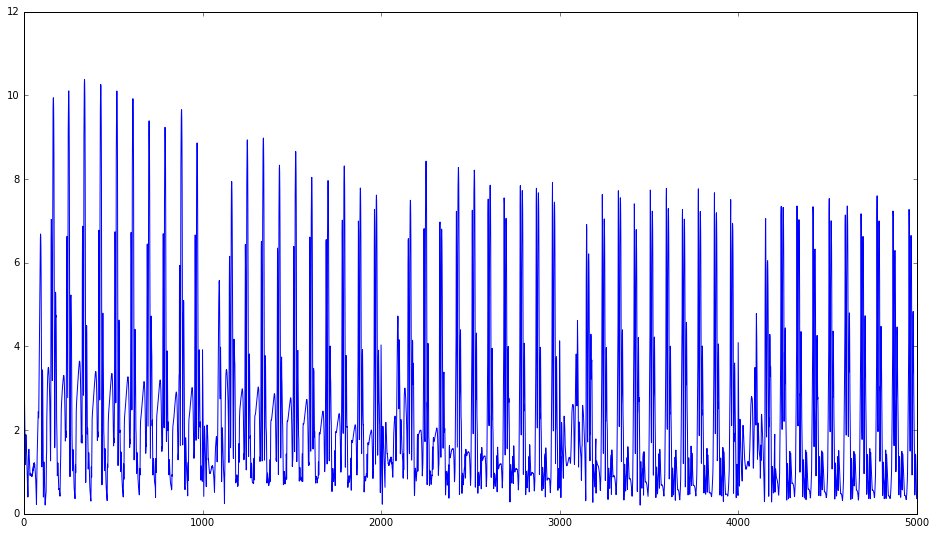

In [9]:
plt.figure(figsize=(16,9))
plt.plot(evaluated_cost)
plt.show()

In [10]:
# Simulate learned policy
obs = env.reset()
done = False
never = False
while not never:
    pred_action = sess.run(pred, feed_dict={input: obs.reshape(1,11)})

    obs, r, done, _ = env.step(pred_action)
    env.render()

KeyboardInterrupt: 